## Thought experiment

First we create random term frequencies for a corpus that consists of only 6 terms.

In [1]:
import numpy as np

topic = {}

tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6))))
tfidf

{'cat': 0.15446427482410852,
 'dog': 0.5835344845200967,
 'apple': 0.8357910167758866,
 'lion': 0.4830873915057595,
 'NYC': 0.4479194273957965,
 'love': 0.9065263218524586}

We want to teach the machine how to recognize topics based on term frequencies of the corpus. An example of how a topic vector would look like is shown below:

In [5]:
topic['petness'] = (.3 * tfidf['cat'] +
                    .3 * tfidf['dog'] +
                    0 * tfidf['apple'] +
                    0 * tfidf['lion'] +
                    .2 * tfidf['NYC'] +
                    .2 * tfidf['love'])  # #2

topic['animalness'] = (.1 * tfidf['cat'] +
                       .3 * tfidf['dog'] +
                       .1 * tfidf['apple'] +
                       .5 * tfidf['lion'] +
                       .1 * tfidf['NYC'] +
                       .1 * tfidf['love'])

topic['cityness'] = (.0 * tfidf['cat'] +
                     .1 * tfidf['dog'] +
                     .2 * tfidf['apple'] +
                     .1 * tfidf['lion'] +
                     .5 * tfidf['NYC'] +
                     .1 * tfidf['love'])
topic

{'petness': 0.49228877765291257,
 'animalness': 0.6510741451937337,
 'cityness': 0.5884327368409071}

The relationships between words and topics can be flipped. If we treat "petness", "animalness", and "cityness" as 3 dimensions, we can create a 3 x 6 matrix.

In [6]:
word_vector = {}

word_vector['cat'] = .3*topic['petness'] + \
                     .1*topic['animalness'] + \
                     0*topic['cityness']

word_vector['dog'] = .3*topic['petness'] + \
                     .1*topic['animalness'] + \
                     .1*topic['cityness']

word_vector['apple'] = 0*topic['petness'] + \
                       .1*topic['animalness'] + \
                       .2*topic['cityness']

word_vector['lion'] = 0*topic['petness'] + \
                      .5*topic['animalness'] + \
                      .1*topic['cityness']

word_vector['NYC'] = .2*topic['petness'] + \
                     .1*topic['animalness'] + \
                     .5*topic['cityness']

word_vector['love'] = .2*topic['petness'] + \
                      .1*topic['animalness'] + \
                      .1*topic['cityness']

In [10]:
word_vector

{'cat': 0.21279404781524713,
 'dog': 0.27163732149933784,
 'apple': 0.1827939618875548,
 'lion': 0.3843803462809576,
 'NYC': 0.4577815384704095,
 'love': 0.2224084437340466}

## Toxic comments

In [11]:
import pandas as pd

url = 'https://gitlab.com/tangibleai/nlpia/-/raw/master/src/nlpia/data/toxic_comment_small.csv'

comments = pd.read_csv(url)
comments.head()

,text,toxic
0,you have yet to identify where my edits violat...,0
1,"""\n as i have already said,wp:rfc or wp:ani. (...",0
2,your vote on wikiquote simple english when it ...,0
3,your stalking of my edits i've opened a thread...,0
4,straight from the smear site itself. the perso...,1


In [19]:
index = ['comments{}{}'.format(i, '!'*j) for i, j in zip(range(len(comments)), comments.toxic)]

comments = pd.DataFrame(comments.values, columns=comments.columns, index=index)
mask = comments.toxic.astype(bool).values

comments['toxic'] = comments.toxic.astype(int)

print('Number of comments:', len(comments))
print('Number of toxic comments:', comments.toxic.sum())
comments.head()

Number of comments: 5000
Number of toxic comments: 650


,text,toxic
comments0,you have yet to identify where my edits violat...,0
comments1,"""\n as i have already said,wp:rfc or wp:ani. (...",0
comments2,your vote on wikiquote simple english when it ...,0
comments3,your stalking of my edits i've opened a thread...,0
comments4!,straight from the smear site itself. the perso...,1


Try solving with TF-IDF.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

nlp = spacy.load('en_core_web_sm')

def spacy_tokenize(sentence):
    return [word.text for word in nlp(sentence.lower())]

tfidf_model = TfidfVectorizer(tokenizer=spacy_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=comments.text).toarray()
tfidf_docs.shape

c:\Users\lived\.conda\envs\nlpia\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5000, 19160)

The spaCy tokenizer gave you 19,169 words in your vocabulary. You have almost 4 times as many words as you have messages. And you have almost 30 times as many words as toxic comments. So your model will not have a lot of information about the words that will indicate whether a comment is toxic or not.

## Latent Discriminant Analysis (LDA)

In [25]:
mask = comments.toxic.astype(bool).values
toxic_centroid = tfidf_docs[mask].mean(axis=0)
nontoxic_centroid = tfidf_docs[~mask].mean(axis=0)

print('toxic_centroid:', toxic_centroid)
print('nontoxic_centroid:', nontoxic_centroid)

toxic_centroid: [0.01406157 0.00363202 0.         ... 0.         0.         0.        ]
nontoxic_centroid: [1.89710535e-02 4.58793799e-03 2.57451586e-04 ... 2.47852092e-05
 1.78452160e-05 6.71831573e-05]


In [26]:
centroid_axis = toxic_centroid - nontoxic_centroid
toxicity_score = tfidf_docs.dot(centroid_axis)
toxicity_score.round(3)

array([-0.008, -0.022, -0.014, ..., -0.025, -0.001, -0.022])

In [28]:
from sklearn.preprocessing import MinMaxScaler

comments['manual_score'] = MinMaxScaler().fit_transform(toxicity_score.reshape(-1, 1))
comments['manual_predict'] = (comments.manual_score > .5).astype(int)
comments['toxic manual_predict manual_score'.split()].round(2)

,toxic,manual_predict,manual_score
comments0,0,0,0.41
comments1,0,0,0.27
comments2,0,0,0.35
comments3,0,0,0.47
comments4!,1,0,0.48
...,...,...,...
comments4995,0,0,0.22
comments4996,0,0,0.36
comments4997!,1,0,0.25
comments4998!,1,0,0.48


In [29]:
correct_predictions = (1 - (comments.toxic - comments.manual_predict).abs()).sum() / len(comments)
correct_predictions

0.8944

89.5% of predictions are correc tusing an "approximate" version of LDA. Let's see the result with a "full" LDA.

In [37]:
from sklearn import discriminant_analysis
lda_tfidf = discriminant_analysis.LinearDiscriminantAnalysis()

lda_tfidf = lda_tfidf.fit(tfidf_docs, comments.toxic)

In [34]:
comments['lda_predict'] = lda_tfidf.predict(tfidf_docs)
comments['lda_predict']

comments0        0
comments1        0
comments2        0
comments3        0
comments4!       1
                ..
comments4995     0
comments4996     0
comments4997!    1
comments4998!    1
comments4999     0
Name: lda_predict, Length: 5000, dtype: int32

In [36]:
lda_tfidf.score(tfidf_docs, comments.toxic)

0.9992

We have 99.92% correct, which is better but this is because we didn't split the docs into train set and test set, which could have resulted in overfitting.

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, comments.toxic, test_size=0.2)
lda_tfidf = discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)
lda = lda_tfidf.fit(X_train, y_train)
round(float(lda.score(X_train, y_train)), 3), round(float(lda.score(X_test, y_test)), 3)

(0.993, 0.799)

The test set has significantly lower accuracy than the train set. Topic modeling can help solve this problem. It allows you to generalize the models from a small training set, so that it still works well on messages using different combinations of words.

### Confusion matrix

The confusion matrix will tell you the number of times the model made a mistake. There are two kinds of mistakes, false positive mistakes and false negative mistakes.

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lda.predict(X_test))

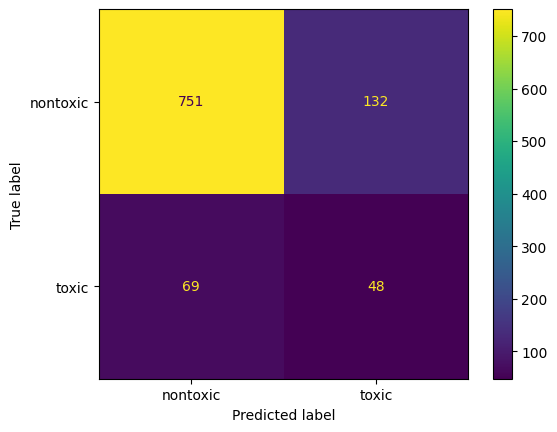

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, display_labels=['nontoxic', 'toxic'])
disp.plot()